In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
import gtfparse


intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)

long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])

long_table['gene'] = [x.split('.')[0] for x in long_table.gene]

del intron_annot
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

expressed_genes.gene = [x.split('.')[0] for x in expressed_genes.gene]

In [2]:
long_table = long_table.loc[long_table.Dataset == 'chRNA.Expression.Splicing']

gene_total = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.sum()).reset_index()
gene_total.columns = ['gene', 'IndID', 'gene_total']

gene_max = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.max()).reset_index()
gene_max.columns = ['gene', 'IndID', 'gene_max']

long_table = long_table.merge(gene_total, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']).merge(
    gene_max, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']
)

long_table['PSI_total'] = long_table.Count/long_table.gene_total
long_table['PSI'] = long_table.Count/long_table.gene_max


In [3]:
long_table = long_table.loc[long_table.gene.isin(expressed_genes.gene)]

NMD = ['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
PC = ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']



In [4]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
RPKM.index = [x.split('.')[0] for x in RPKM.index]

log2RPKM = RPKM[RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
log2RPKM.columns = ['gene', 'RPKM']

In [5]:
nmd_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum())

idx = nmd_counts.index

pc_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(PC)].groupby('gene').Count.sum()).reindex(idx).fillna(0)


psi = (nmd_counts.Count/(pc_counts.Count + nmd_counts.Count))

In [6]:
exon_counts = pd.read_csv('../code/exons.appris_principal.basic_annotation.bed.gz', sep='\t')
exon_counts.columns = ['chrom', 'start', 'end', 'gene', 'symbol', 'strand', 'transcript']
exon_counts.gene = [x.split('.')[0] for x in exon_counts.gene]
exon_counts['exon_count'] = 1

In [7]:
from scipy.stats import entropy

long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
# long_summary = long_summary.merge(pd.DataFrame(
#     exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
# ), left_on='gene', right_index=True)

idx = psi.index

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []
entropy_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    if gene not in idx:
        continue
    
    suma = int(nmd_counts.loc[gene].Count)
    
    suma_list.append(suma)
    
#     intron_counts = list(df.exon_count)[0]
#     intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    entropy_ = entropy(rank_percent)
    entropy_list.append(entropy_)
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = np.sum(rank_percent[4:])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, entropy_list]).T
df_summary.columns = ['total_reads', 'entropy']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11586/11586 [00:07<00:00, 1551.60it/s]


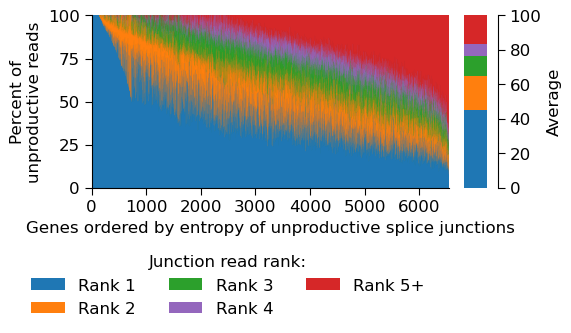

In [8]:
plt.rcParams['legend.title_fontsize'] = 12

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5.24, 2.24), gridspec_kw={'width_ratios': [8, 1], 
                                                                       'wspace': 0.02})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.01)].index

top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()

df_idx = rank_.index

i = 0

df_rank_ = 100*df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


for idx, row in df_rank_.loc[entropy_idx].iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes ordered by entropy of unproductive splice junctions', size=12)
ax[0].set_ylabel('Percent of\nunproductive reads', size=12)

# ax[0].set_ylim([0, 100])
ax[0].margins(x=0, y=0)
# ax[0].set_xlim([0, i])
# ax[1].set_ylim([0, 100])

# ax[1].set_xlim([-0.25, 0.25])

# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

# ax[1].set_ylabel('Average percent of\nunproductive reads', size=12)

ax[1].set_xticks([])
ax[1].legend(bbox_to_anchor=(-0.3, -0.3), frameon=False, title = 'Junction read rank:', fontsize=12, ncols=3)

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)



ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

ax[1].set_ylabel('Average', size=12)
ax[1].margins(x=0, y=0)

# y = ax[1].secondary_yaxis('right')
# y.set_ticks([0, 20, 40, 60, 80, 100], ['0', '20', '40', '60', '80', '100'], fontsize=12)


fig_dir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(fig_dir + 'Read_ranks.100reads_1_to_20_percent_NMD.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(fig_dir + 'Read_ranks.100reads_1_to_20_percent_NMD.png', dpi=2000, bbox_inches='tight', transparent=True)

In [16]:
df_idx

Index(['ENSG00000141337', 'ENSG00000167716', 'ENSG00000106125',
       'ENSG00000115841', 'ENSG00000006607', 'ENSG00000156831',
       'ENSG00000144445', 'ENSG00000177943', 'ENSG00000198286',
       'ENSG00000146350',
       ...
       'ENSG00000185420', 'ENSG00000153898', 'ENSG00000104731',
       'ENSG00000197410', 'ENSG00000091622', 'ENSG00000124786',
       'ENSG00000103496', 'ENSG00000143499', 'ENSG00000178078',
       'ENSG00000138002'],
      dtype='object', length=6549)

In [17]:
(psi >= 0.01).sum()

8385

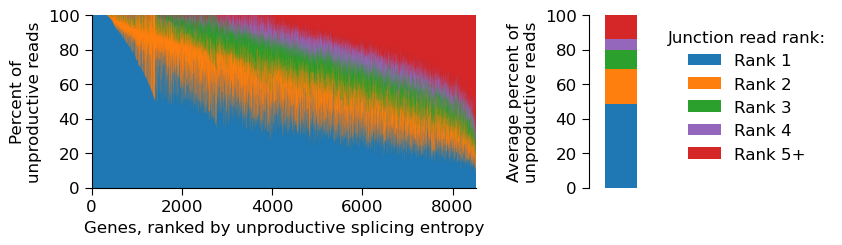

In [10]:
plt.rcParams['legend.title_fontsize'] = 12

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7.24, 2.24), gridspec_kw={'width_ratios': [6, 1], 
                                                                       'wspace': 0.5})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.001)].index

top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()

df_idx = rank_.index

i = 0

df_rank_ = 100*df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


for idx, row in df_rank_.loc[entropy_idx].iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes, ranked by unproductive splicing entropy', size=12)
ax[0].set_ylabel('Percent of\nunproductive reads', size=12)

ax[0].set_ylim([0, 100])
ax[0].set_xlim([0, i])
ax[1].set_ylim([0, 100])


# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[1].set_ylabel('Average percent of\nunproductive reads', size=12)

ax[1].set_xticks([])
ax[1].legend(bbox_to_anchor=(1, 1), frameon=False, title = 'Junction read rank:', fontsize=12)

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)


fig_dir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(fig_dir + 'Read_ranks.100reads_0.1_to_20_percent_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'Read_ranks.100reads_0.1_to_20_percent_NMD.png', dpi=300, bbox_inches='tight',)

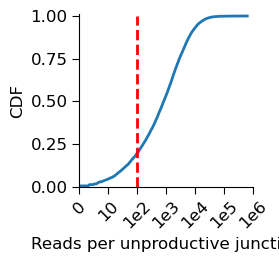

In [17]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

x = np.linspace(np.log10(long_summary.groupby('gene').Count.sum()).min(), 
                np.log10(long_summary.groupby('gene').Count.sum()).max(), 100)
y = [(np.log10(long_summary.groupby('gene').Count.sum()) <= z).mean() for z in x]
ax.plot(x, y, linewidth=2)
ax.set_xlabel('Reads per unproductive junction', size=12)
ax.set_ylabel('CDF', size=12)
# plt.xlim([-1, 51])
ax.set_xticks(range(7))
ax.set_xticklabels(['0', '10', '1e2', '1e3', '1e4', '1e5', '1e6'], size=12, rotation=45)
ax.plot([2, 2], [0, 1], 'r--', linewidth=2)
ax.set_xlim([0, 6])
ax.set_ylim([0, 1.01])
ax.tick_params(length=5, labelsize=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(fig_dir + 'NMD_reads_per_junction.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'NMD_reads_per_junction.png', dpi=300, bbox_inches='tight',)

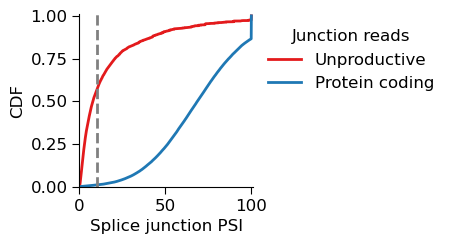

In [18]:
long_table_sum = long_table.groupby(['gene', 'symbol', 'junction', 'NewAnnotation', 'SuperAnnotation']
                                   ).Count.sum().reset_index()

gene_total_sum = pd.DataFrame(long_table_sum.groupby(['gene']).Count.max()).reset_index()
gene_total_sum.columns = ['gene',  'gene_max']

long_table_sum = long_table_sum.merge(gene_total_sum, left_on='gene', right_on='gene')
long_table_sum['PSI'] = long_table_sum.Count/long_table_sum.gene_max

long_table_sum_NMD = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(NMD)]
long_table_sum_PC = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(PC)]
x = np.linspace(0, 1, 1001)
contribution_NMD = [long_table_sum_NMD.loc[long_table_sum_NMD.PSI <= y].Count.sum() for y in x]
contribution_PC = [long_table_sum_PC.loc[long_table_sum_PC.PSI <= y].Count.sum() for y in x]

fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.plot(x*100, np.array(contribution_NMD)/np.max(contribution_NMD), label='Unproductive', c='#e31a1c', linewidth=2)
ax.plot(x*100, np.array(contribution_PC)/np.max(contribution_PC), label='Protein coding', c='#1f78b4', linewidth=2)
ax.plot([10, 10], [0, 100], linestyle='--', c='gray', linewidth=2)
ax.set_xlabel('Splice junction PSI', size=12)
ax.set_ylabel('CDF', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12, title = 'Junction reads')

ax.set_xlim([0, 101])
ax.set_ylim([0, 1.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)

plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.png', dpi=300, bbox_inches='tight')

In [9]:
long_table_PSI = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(
    ['gene', 'symbol', 'junction']).PSI.mean().reset_index().groupby(['gene', 'symbol']).PSI.max().reset_index()

NMD_counts = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'symbol']).Count.sum().reset_index()
NMD_counts.columns = ['gene', 'symbol', 'NMD_counts']
junc_counts = long_table.groupby(['gene', 'symbol']).Count.sum().reset_index()
junc_counts.columns = ['gene', 'symbol', 'junc_counts']

junc_counts = junc_counts.merge(NMD_counts, left_on=['gene', 'symbol'], right_on=['gene', 'symbol'])
junc_counts['NMD_percent'] = junc_counts.NMD_counts/junc_counts.junc_counts

In [10]:
NMD_by_gene = long_table_PSI.merge(junc_counts, left_on=['gene', 'symbol'], right_on=['gene', 'symbol']).merge(
log2RPKM, left_on='gene', right_on='gene').merge(df_rank, left_on='gene', right_index=True)

NMD_by_gene['TPM'] = 1e6*np.exp(NMD_by_gene.RPKM)/np.sum(np.exp(NMD_by_gene.RPKM))
NMD_by_gene['logTPM'] = np.log2(1e6*np.exp(NMD_by_gene.RPKM)/np.sum(np.exp(NMD_by_gene.RPKM)))
NMD_by_gene['NMD_transcripts'] = NMD_by_gene.TPM*NMD_by_gene.PSI



In [11]:
transcription_factors = []
splicing_factors = []
translation = []
histone_activity = []
rbps = []
with open('../../c5.all.v2023.1.Hs.symbols.gmt') as fh:#open('../../c5.go.bp.v2023.1.Hs.symbols.gmt') as fh:
    for line in fh:
        line = line.rstrip().split('\t')
        if (line[0][:5] == 'GOBP_') and (('TRANSCRIPTION_FACTOR' in line[0]) or ('TRANSCRIPTION_INITIATION' in line[0]) or ('TRANSCRIPTION_ELONGATION' in line[0])):
            transcription_factors.extend(line[2:])
        elif (line[0][:5] == 'GOBP_') and (('SPLICING' in line[0]) or ('SPLICE_SITE' in line[0])):
            splicing_factors.extend(line[2:])
        elif (line[0][:5] == 'GOBP_') and ((('HISTONE' in line[0]) or ('_CHROMATIN_ORGANIZATION' in line[0]) or ('_CHROMATIN_REMODELING' in line[0]))):
            histone_activity.extend(line[2:])
        elif (line[0][:5] == 'GOBP_') and (('TRANSLATION' in line[0])):
            translation.extend(line[2:])
        elif ('GOMF_RNA_BINDING' in line[0]):
            rbps.extend(line[2:])
        
            
transcription_factors = sorted(set(transcription_factors))
splicing_factors = sorted(set(splicing_factors))
translation = sorted(set(translation))
histone_activity = sorted(set(histone_activity))
rbps = sorted(set(rbps))

annotation = []
for gene in NMD_by_gene.symbol:
    if gene in transcription_factors:
        annotation.append('Transcription factors')
    elif gene in splicing_factors:
        annotation.append('Splicing factors')
#     elif gene in kinases:
#         annotation.append('Kinases')
    elif gene in translation:
        annotation.append('Translation factors')
    elif gene in histone_activity:
        annotation.append('Chromatin factors')
#     elif gene in rbps:
#         annotation.append('Other RBP')
    else:
        annotation.append('Other')
        
NMD_by_gene['annotation'] = annotation

In [12]:
scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)

genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(pd.Index(NMD_by_gene.gene))

NMD_by_gene = NMD_by_gene.merge(scores, left_on='gene', right_index=True)

In [13]:
ranks = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']

In [13]:
NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Splicing factors'), ranks].mean(axis=0)

NameError: name 'entropy_idx' is not defined

In [418]:
NMD_by_gene_selected = NMD_by_gene#.loc[NMD_by_gene.gene.isin(entropy_idx)]

def get_slice(df, i, step=0.1, attribute='PSI'):
    qi = df[attribute].quantile(i)
    qi0 = df[attribute].quantile(i-step)
    df_counts = df.loc[(df[attribute] <= qi) & (df[attribute] >= qi0)]['annotation'].value_counts()
    df_frac = pd.DataFrame(df_counts/1).T
    df_frac.index = ['Q' + str(int((i/step)))]
    return df_frac

In [419]:
top_genes = NMD_by_gene_selected.loc[
    (NMD_by_gene_selected.RPKM > NMD_by_gene_selected.RPKM.quantile(0.75)) & (
    NMD_by_gene_selected.post_mean > NMD_by_gene_selected.post_mean.quantile(0.75))]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 8 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 

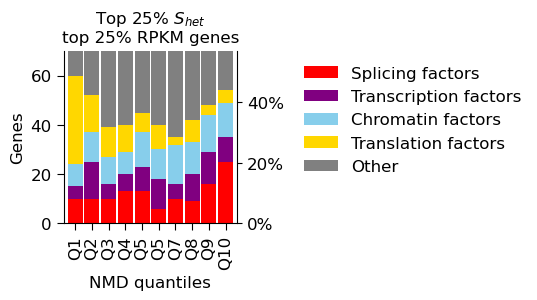

In [420]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

top_genes = NMD_by_gene.loc[
    (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.1) for i in np.linspace(0.1, 1, 10)], axis=0)
df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Translation factors', 'Other']].plot(
    kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
                                   #        'Kinases', 'Other RBP', 'Splicing factors'],
        color=['red', 'purple', 'skyblue', 'gold', 'grey'], ax=ax, width=0.9)
ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), fontsize=12)
ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0,70])

ax.set_xlabel('NMD quantiles', size=12)
ax.set_ylabel('Genes', size=12)

y = ax.secondary_yaxis('right')
y.set_ticks([0, 24.6, 49.2], ['0%', '20%', '40%'], fontsize=12)
figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_SF_NMD_barplot.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_SF_NMD_barplot.png', dpi=300, bbox_inches='tight',)

In [19]:
top_genes.loc[top_genes.annotation=='Splicing factors', 'Rank 5+'].mean()

0.0642276979814627

In [20]:
top_genes.loc[top_genes.annotation=='Transcription factors', 'Rank 5+'].mean()

0.12061048447008049

In [21]:
df_rank_.loc[df_idx].mean(axis=0)

Rank 1     45.119028
Rank 2     20.054640
Rank 3     11.385060
Rank 4      7.081601
Rank 5+    16.359670
dtype: float64

In [50]:
# fig, ax = plt.subplots(figsize=(2.24, 2.24))

# top_genes = NMD_by_gene.loc[
#     (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

# df = pd.concat([get_slice(top_genes, i, 0.1) for i in np.linspace(0.1, 1, 10)], axis=0)
# df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Other']].plot(
#     kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
#                                    #        'Kinases', 'Other RBP', 'Splicing factors'],
#         color=['red', 'purple', 'skyblue', 'grey'], ax=ax, width=0.9)
# ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
# ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), fontsize=12)
# ax.tick_params(length=5, labelsize=12)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# ax.set_ylim([0,60])

# ax.set_xlabel('NMD quantiles', size=12)
# ax.set_ylabel('Genes', size=12)

# y = ax.secondary_yaxis('right')
# y.set_ticks([0, 24.6, 49.2], ['0%', '20%', '40%'], fontsize=12)
# figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

# plt.savefig(figdir + 'Supp_SF_NMD_barplot.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'Supp_SF_NMD_barplot.png', dpi=300, bbox_inches='tight',)

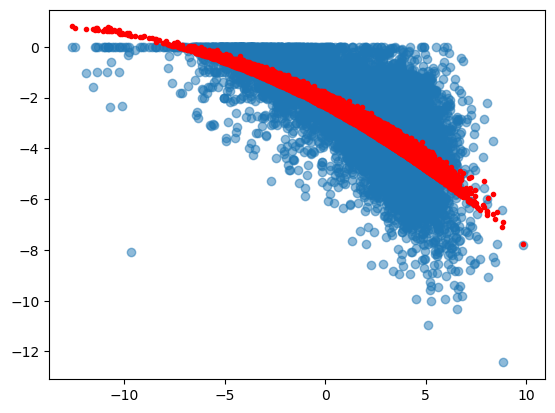

In [17]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

NMD_by_gene['log2_s_score'] = np.log2(NMD_by_gene.post_mean)

x = NMD_by_gene[['RPKM', 'log2_s_score']]

# x = NMD_by_gene.RPKM
y = np.log2(NMD_by_gene.PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly2.fit_transform(np.array(x))#.reshape(-1, 1))
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,np.array(y).reshape(-1, 1))
poly_pred = poly_model.predict(X_poly)
# Plot
plt.scatter(x.RPKM,y, alpha=0.5)
plt.plot(x.RPKM, poly_pred, color='red', linestyle='', marker='.', lw=0.1);


resid = np.array(y) - poly_pred.T[0]
NMD_by_gene['resid'] = resid

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 8 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 

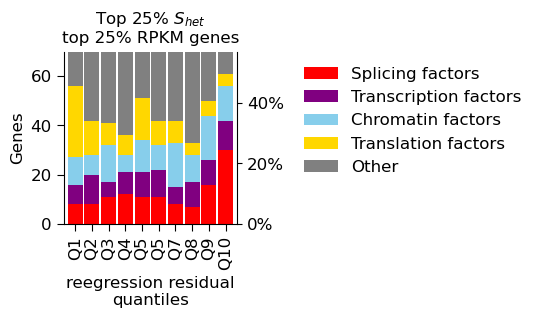

In [74]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

top_genes = NMD_by_gene.loc[
    (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.1, 'resid') for i in np.linspace(0.1, 1, 10)], axis=0)
df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Translation factors', 'Other']].plot(
    kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
                                   #        'Kinases', 'Other RBP', 'Splicing factors'],
        color=['red', 'purple', 'skyblue', 'gold', 'grey'], ax=ax, width=0.9)
ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), fontsize=12)
ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0,70])

ax.set_xlabel('reegression residual\nquantiles', size=12)
ax.set_ylabel('Genes', size=12)

y = ax.secondary_yaxis('right')
y.set_ticks([0, 24.6, 49.2], ['0%', '20%', '40%'], fontsize=12)
figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_SF_NMD_barplot_resid.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_SF_NMD_barplot_resid.png', dpi=300, bbox_inches='tight',)

In [76]:
df.sum().sum()

1224.0

In [78]:
df

,Other,Translation factors,Chromatin factors,Transcription factors,Splicing factors
Q1,66.0,29.0,11.0,8.0,8.0
Q2,80.0,14.0,8.0,12.0,8.0
Q3,82.0,9.0,15.0,6.0,11.0
Q4,86.0,8.0,7.0,9.0,12.0
Q5,72.0,17.0,13.0,10.0,11.0
Q5,80.0,10.0,10.0,11.0,11.0
Q7,80.0,9.0,18.0,7.0,8.0
Q8,90.0,5.0,11.0,10.0,7.0
Q9,72.0,6.0,18.0,10.0,16.0
Q10,62.0,5.0,14.0,12.0,30.0


In [44]:
from scipy.stats import kruskal, hypergeom
def hypergeom_test(k, M, n, N):
    '''
    k = Objects drawn belonging to class of interest
    M = Total number of objects
    n = Total number of objects belonging to class of interest
    N = Objects drawn without replacement
    '''
    enrichment = (k/N)/(n/M)
    pval_enrich = hypergeom.sf(k, M, n, N)
    return enrichment, pval_enrich

In [81]:
# Splicing factors
hypergeom_test(30, 1225, 123, 123)

(2.429109656950228, 1.947244270786833e-07)

In [85]:
# Translation factors
hypergeom_test(30, 1225, 113, 123)

(2.644075113317505, 2.14225781747646e-08)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 8 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 

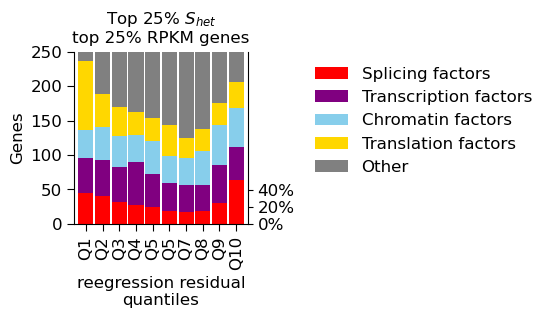

In [43]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

# top_genes = NMD_by_gene.loc[
#     (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(NMD_by_gene, i, 0.1, 'resid') for i in np.linspace(0.1, 1, 10)], axis=0)
df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Translation factors', 'Other']].plot(
    kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
                                   #        'Kinases', 'Other RBP', 'Splicing factors'],
        color=['red', 'purple', 'skyblue', 'gold', 'grey'], ax=ax, width=0.9)
ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), fontsize=12)
ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0,250])

ax.set_xlabel('reegression residual\nquantiles', size=12)
ax.set_ylabel('Genes', size=12)

y = ax.secondary_yaxis('right')
y.set_ticks([0, 24.6, 49.2], ['0%', '20%', '40%'], fontsize=12)
figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_SF_NMD_barplot_resid_allgenes.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_SF_NMD_barplot_resid_allgenes.png', dpi=300, bbox_inches='tight',)

In [53]:
other_sf = ['MBNL1', 'SNRNP70', 'SMNDC1']
other_sf_ensembl = genes.loc[genes.genes.isin(other_sf)].index.intersection(RPKM.index)

df_rank.loc[srsf_ensembl].mean(axis=0)

Rank 1     0.649233
Rank 2     0.214637
Rank 3     0.072311
Rank 4     0.029554
Rank 5+    0.034264
dtype: float64

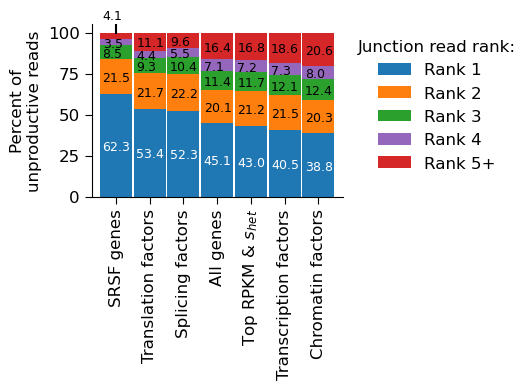

In [54]:
df_bar = pd.DataFrame()
df_bar['All genes'] = df_rank_.loc[df_idx].mean(axis=0)/100#

df_bar['Top RPKM & $s_{het}$'] = top_genes.loc[top_genes.gene.isin(entropy_idx), 
                                            ranks].mean(axis=0)

df_bar['SRSF genes'] = top_genes.loc[top_genes.gene.isin(srsf_ensembl), #& (top_genes.annotation=='Splicing factors'), 
                                             ranks].mean(axis=0)

df_bar['Splicing factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Splicing factors'), 
                                             ranks].mean(axis=0)
df_bar['Transcription factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Transcription factors'), 
                                             ranks].mean(axis=0)
df_bar['Chromatin factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Chromatin factors'), 
                                             ranks].mean(axis=0)

df_bar['Translation factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Translation factors'), 
                                             ranks].mean(axis=0)

df_bar['Other'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Other'), 
                                             ranks].mean(axis=0)

df_bar = 100*df_bar

fig, ax = plt.subplots(figsize=(3.24, 2.24))


gene_types = ['SRSF genes', 'Translation factors', 'Splicing factors', 'All genes', 'Top RPKM & $s_{het}$', 'Transcription factors', 'Chromatin factors']

df_bar[gene_types].T.plot(kind='bar', stacked=True, color=[
    'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red'], width=0.95, ax=ax)


for i in range(7):
    ax.text(i-0.4, df_bar.loc['Rank 1', gene_types[i]]/2-3, '{0:.1f}'.format(df_bar.loc['Rank 1', gene_types[i]]), 
            rotation = 0, c='white', size=9)
    
    ax.text(i-0.4, df_bar.loc['Rank 1', gene_types[i]]+df_bar.loc['Rank 2', gene_types[i]]/2-3, 
            '{0:.1f}'.format(df_bar.loc['Rank 2', gene_types[i]]), 
            rotation = 0, c='black', size=9)
    
    ax.text(i-0.4, df_bar.loc['Rank 1', gene_types[i]]+df_bar.loc['Rank 2', gene_types[i]]+df_bar.loc['Rank 3', gene_types[i]]/2-3, 
            '{0:.1f}'.format(df_bar.loc['Rank 3', gene_types[i]]), 
            rotation = 0, c='black', size=9)
    
    ax.text(i-0.4, df_bar.loc['Rank 1', gene_types[i]]+df_bar.loc['Rank 2', gene_types[i]]+df_bar.loc['Rank 3', gene_types[i]]+df_bar.loc['Rank 4', gene_types[i]]/2-3, 
            '{0:.1f}'.format(df_bar.loc['Rank 4', gene_types[i]]), 
            rotation = 0, c='black', size=9)
    
    if i < 1:
        ax.text(i-0.4, 108, 
                '{0:.1f}'.format(df_bar.loc['Rank 5+', gene_types[i]]), 
                rotation = 0, c='black', size=9)
        if i < 1:
            ax.plot([i, i], [100, 105], c='black')
        else:
            ax.plot([i, i], [98, 105], c='black')
    else:
        ax.text(i-0.4, 100-df_bar.loc['Rank 5+', gene_types[i]]/2-3, 
            '{0:.1f}'.format(df_bar.loc['Rank 5+', gene_types[i]]), 
            rotation = 0, c='black', size=9)

ax.legend(bbox_to_anchor=(1,1), frameon=False, title = 'Junction read rank:', fontsize=12)

ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim([0, 100])
ax.margins(x=0, y=0)


ax.set_ylabel('Percent of\nunproductive reads', size=12)

plt.savefig(figdir + 'Supp_read_ranks_by_annotation.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_read_ranks_by_annotation.png', dpi=300, bbox_inches='tight',)

In [55]:
df_bar = pd.DataFrame()
df_bar['All genes'] = df_rank_.loc[df_idx].mean(axis=0)/100#

df_bar['Top RPKM & $s_{het}$'] = top_genes.loc[top_genes.gene.isin(entropy_idx), 
                                            ranks].mean(axis=0)

df_bar['SRSF genes'] = top_genes.loc[top_genes.gene.isin(srsf_ensembl), #& (top_genes.annotation=='Splicing factors'), 
                                             ranks].mean(axis=0)

df_bar['Splicing factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Splicing factors'), 
                                             ranks].mean(axis=0)
df_bar['Transcription factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Transcription factors'), 
                                             ranks].mean(axis=0)
df_bar['Chromatin factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Chromatin factors'), 
                                             ranks].mean(axis=0)

df_bar['Translation factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Translation factors'), 
                                             ranks].mean(axis=0)

df_bar['Other'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Other'), 
                                             ranks].mean(axis=0)

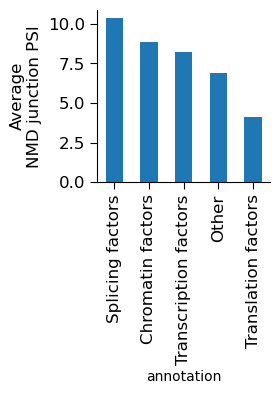

In [209]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

(top_genes.groupby('annotation').PSI.mean()*100).sort_values(ascending=False).plot(kind='bar', ax=ax)

ax.set_ylabel('Average\nNMD junction PSI', size=12)


ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(figdir + 'Supp_avg_NMD_PSI_by_annotation.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_avg_NMD_PSI_by_annotation.png', dpi=300, bbox_inches='tight',)

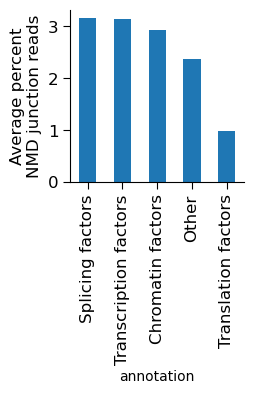

In [210]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))
(top_genes.groupby('annotation').NMD_percent.mean()*100).sort_values(ascending=False).plot(kind='bar', ax=ax)

ax.set_ylabel('Average percent\nNMD junction reads', size=12)


ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(figdir + 'Supp_avg_NMD_percent_by_annotation.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_avg_NMD_percent_by_annotation.png', dpi=300, bbox_inches='tight',)

<Axes: xlabel='annotation'>

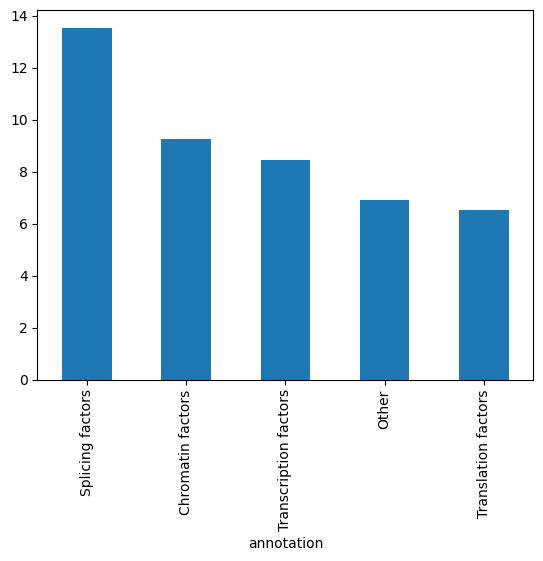

In [181]:
top_genes.groupby('annotation').NMD_transcripts.median().sort_values(ascending=False).plot(kind='bar')

In [183]:
top_genes['NMD_transcripts_rank1'] = top_genes.TPM*top_genes.PSI*top_genes['Rank 1']


/tmp/ipykernel_3265741/2311603239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_genes['NMD_transcripts_rank1'] = top_genes.TPM*top_genes.PSI*top_genes['Rank 1']


<Axes: xlabel='annotation'>

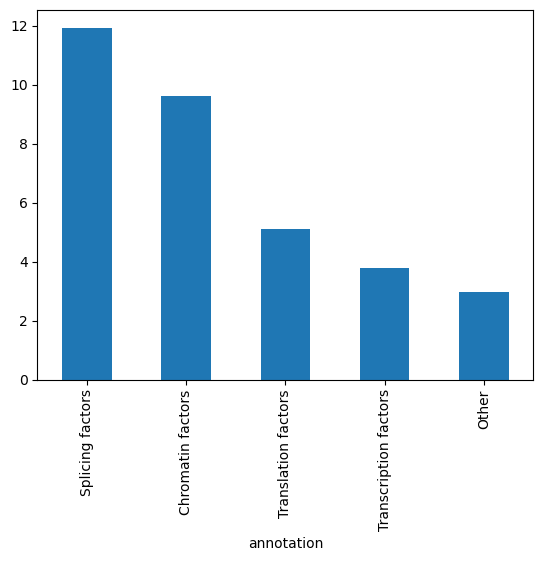

In [184]:
NMD_by_gene.groupby('annotation').NMD_transcripts_rank1.mean().sort_values(ascending=False).plot(kind='bar')

In [199]:
p5 = []
for annot in top_genes.annotation.unique():
    
    p5.append((top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation==annot), 
                                                 'Rank 5+'] == 0).mean())
    
df_5 = pd.DataFrame()
df_5['Percent Rank 5+ == 0'] = p5
df_5.index = top_genes.annotation.unique()


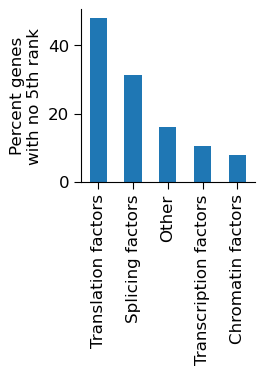

In [213]:

fig, ax = plt.subplots(figsize=(2.24, 2.24))

(df_5['Percent Rank 5+ == 0'].sort_values(ascending=False)*100).plot(kind='bar', ax=ax)

ax.set_ylabel('Percent genes\nwith no 5th rank', size=12)


ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(figdir + 'Supp_percent_no_fifth.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_percent_no_fifth.png', dpi=300, bbox_inches='tight',)

In [39]:
NMD_by_gene.loc[NMD_by_gene.annotation == 'Splicing factors', ranks]

,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5+
29,0.347706,0.324246,0.230665,0.033192,0.064192
38,0.276382,0.276382,0.256281,0.150754,0.040201
63,0.361456,0.358147,0.162117,0.043838,0.074442
118,0.408795,0.217427,0.135179,0.116450,0.122150
191,0.458345,0.444603,0.057067,0.015650,0.024334
...,...,...,...,...,...
11166,0.627976,0.261905,0.108631,0.001488,0.000000
11182,0.340186,0.240749,0.221381,0.151915,0.045769
11186,0.344646,0.315988,0.275264,0.064103,0.000000
11454,0.472441,0.407480,0.081693,0.038386,0.000000


2023-08-21 10:52:53,995 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-21 10:52:54,155 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-21 10:52:58,060 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-21 10:53:08,707 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'O', 'Q', 'R', 'a', 'd', 'e', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [

INFO:fontTools.subset:Closing glyph list over 'glyf': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'eight', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 24, 25, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 43 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'eight', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.su

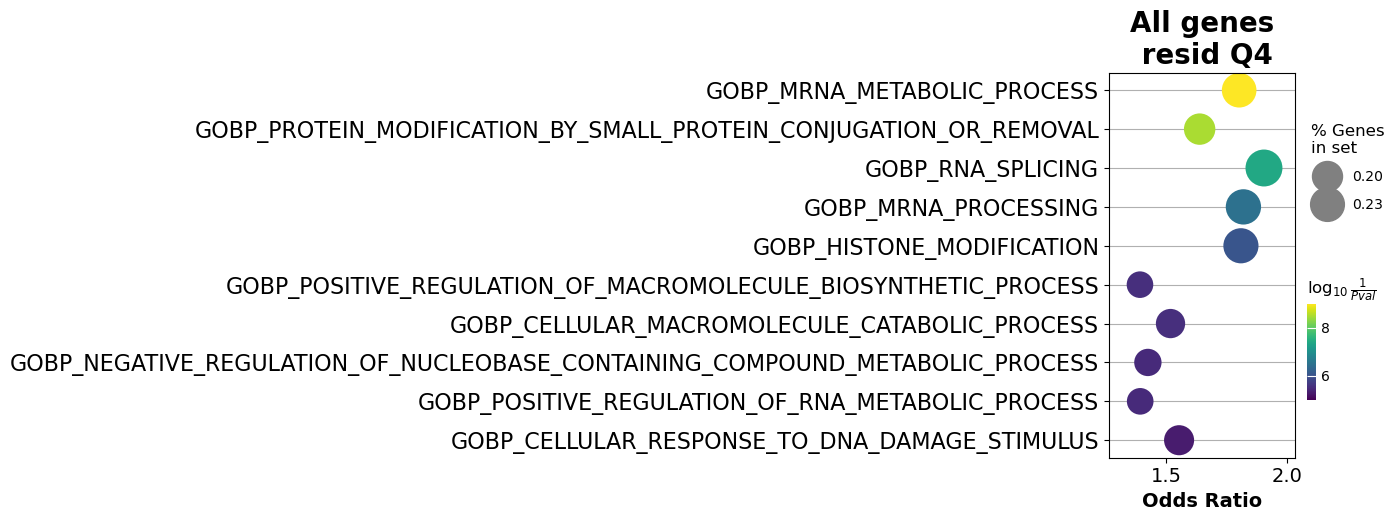

In [56]:
import gseapy as gp
from gseapy import barplot, dotplot

# gene_list = list(top_genes.loc[top_genes.resid > top_genes.resid.quantile(0.75)].symbol)
gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\n resid Q4',cmap='viridis', size=18, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q4.png', dpi=300, bbox_inches='tight',)

2023-08-21 10:55:09,135 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-21 10:55:09,219 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-21 10:55:13,135 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-21 10:55:21,033 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 21 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'O', 'R', 'a', 'c', 'd', 'e', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 's', 'space', 't', 'zero']
INFO:fontTools.subset:Glyph I

INFO:fontTools.subset:Closing glyph list over 'glyf': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 23, 24, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 41 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 

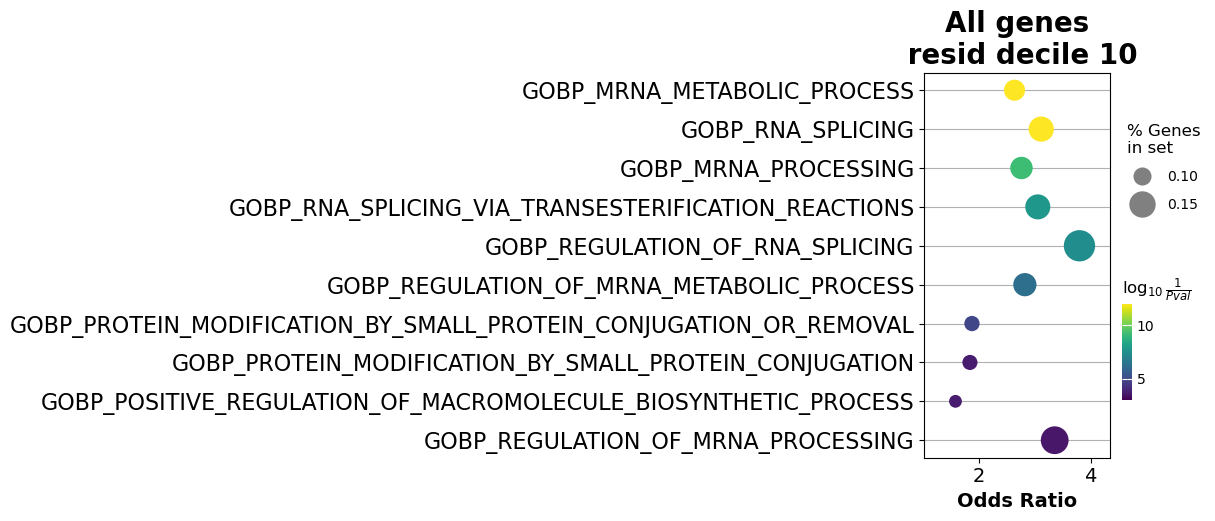

In [57]:
import gseapy as gp
from gseapy import barplot, dotplot

# gene_list = list(top_genes.loc[top_genes.resid > top_genes.resid.quantile(0.75)].symbol)
gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.9)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\n resid decile 10',cmap='viridis', size=20, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q10.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q10.png', dpi=300, bbox_inches='tight',)

In [61]:
NMD_by_gene.shape

(11328, 26)

In [59]:
len(gene_list)

1133

2023-08-18 20:03:47,524 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-18 20:03:47,732 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-18 20:03:51,558 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-18 20:04:02,472 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'O', 'Q', 'R', 'a', 'd', 'e', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 's', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0

INFO:fontTools.subset:Closing glyph list over 'glyf': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 24, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 41 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 

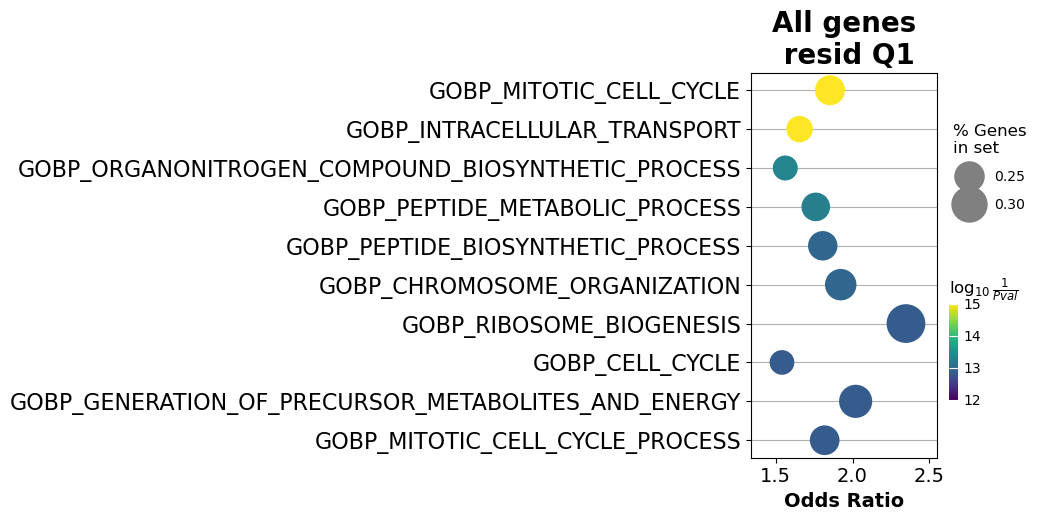

In [38]:
import gseapy as gp
from gseapy import barplot, dotplot

# gene_list = list(top_genes.loc[top_genes.resid > top_genes.resid.quantile(0.75)].symbol)
gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid < NMD_by_gene.resid.quantile(0.25)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\n resid Q1',cmap='viridis', size=14, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q1.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q1.png', dpi=300, bbox_inches='tight',)

2023-08-18 20:04:35,024 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-18 20:04:35,212 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-18 20:04:39,055 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-18 20:04:47,776 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'O', 'R', 'a', 'c', 'd', 'e', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 's', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0

INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 23, 24, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 40 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 23, 24, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 5

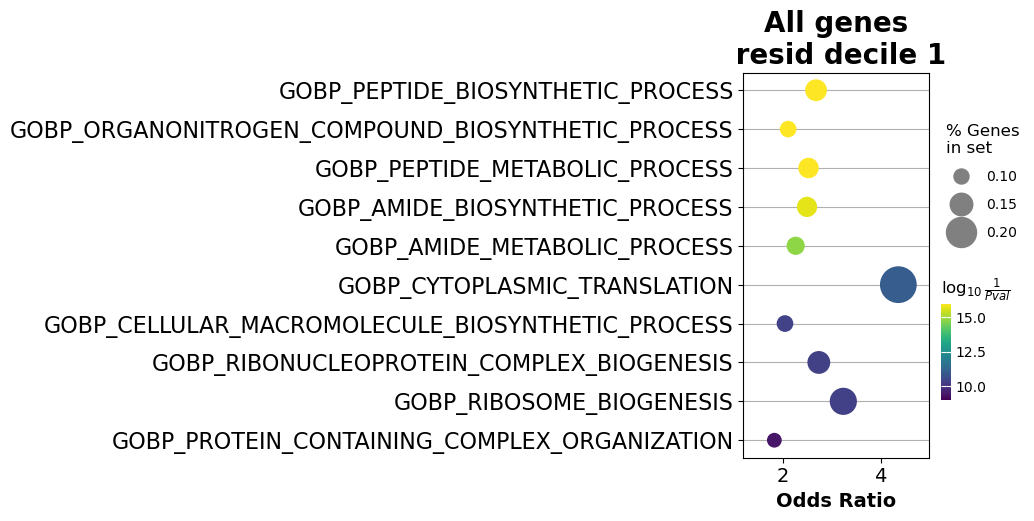

In [39]:
import gseapy as gp
from gseapy import barplot, dotplot

# gene_list = list(top_genes.loc[top_genes.resid > top_genes.resid.quantile(0.75)].symbol)
gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid < NMD_by_gene.resid.quantile(0.1)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\n resid decile 1',cmap='viridis', size=18, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q01.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q01.png', dpi=300, bbox_inches='tight',)

2023-08-21 11:19:40,940 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-21 11:19:41,037 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-21 11:19:45,006 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-21 11:19:50,059 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'I', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'a', 'd', 'e', 'four', 'g', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't']
INFO:f

INFO:fontTools.subset:Closing glyph list over 'glyf': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 24, 36, 37, 38, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 38 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 24, 36, 37, 38, 40, 41, 42, 43, 44, 47, 

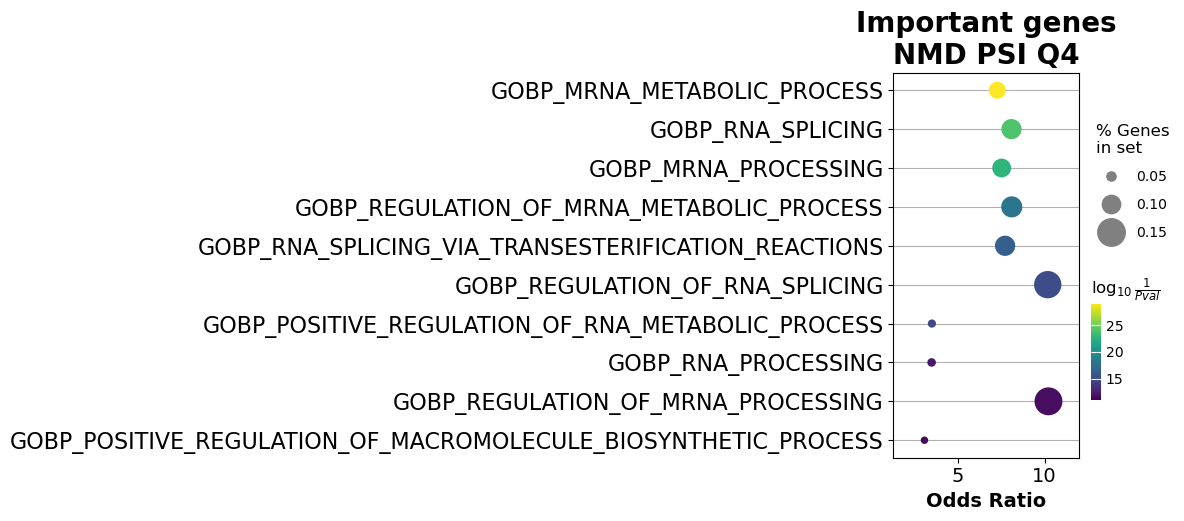

In [86]:
import gseapy as gp
from gseapy import barplot, dotplot

gene_list = list(top_genes.loc[top_genes.PSI > top_genes.PSI.quantile(0.75)].symbol)
# gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes\nNMD PSI Q4',cmap='viridis', size=22, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q4.png', dpi=300, bbox_inches='tight',)

In [87]:
len(gene_list)

306

2023-08-18 13:50:49,044 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-18 13:50:49,133 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-18 13:50:53,021 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-18 13:50:59,155 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'I', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'a', 'd', 'e', 'g', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't']
INFO:fo

INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 25, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', 'e', 'eight', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 25, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 44 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 

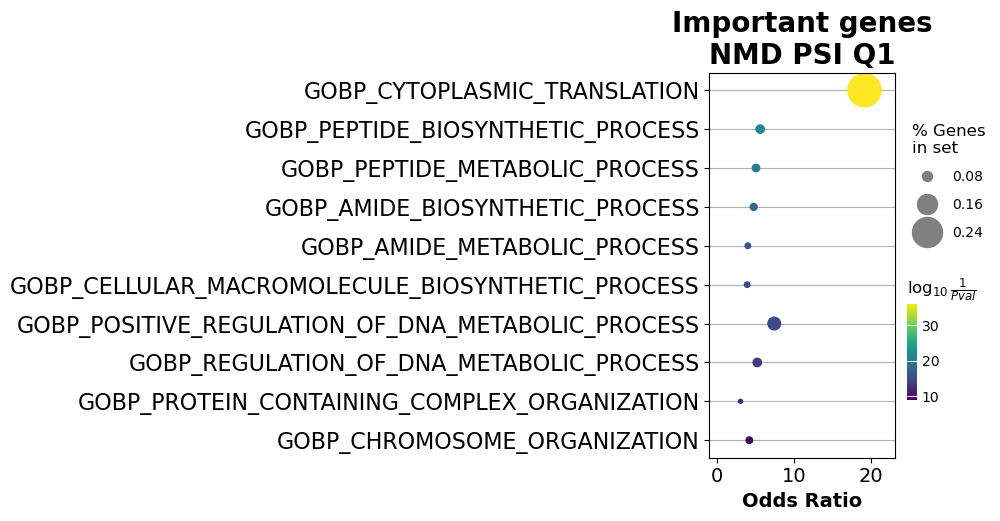

In [32]:
import gseapy as gp
from gseapy import barplot, dotplot

gene_list = list(top_genes.loc[top_genes.PSI < top_genes.PSI.quantile(0.25)].symbol)
# gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes\nNMD PSI Q1',cmap='viridis', size=15, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q1.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q1.png', dpi=300, bbox_inches='tight',)

2023-08-18 13:51:03,200 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-18 13:51:03,288 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-18 13:51:07,186 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-18 13:51:18,045 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 24 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'D', 'M', 'N', 'O', 'Q', 'R', 'T', 'a', 'd', 'e', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't']
INFO:fontTools.su

INFO:fontTools.subset:Closing glyph list over 'glyf': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 24, 36, 37, 38, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 41 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 

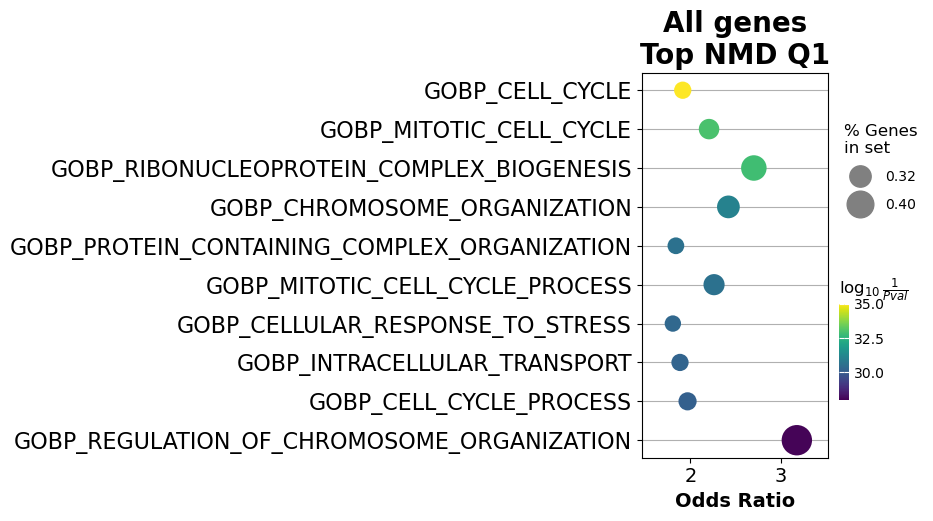

In [33]:
# gene_list = list(NMD_by_gene.sort_values('PSI').symbol)[-200:]
gene_list = list(NMD_by_gene.loc[NMD_by_gene.PSI < NMD_by_gene.PSI.quantile(0.25)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\nTop NMD Q1',cmap='viridis', size=8, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q1.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q1.png', dpi=300, bbox_inches='tight',)

2023-08-18 13:51:19,484 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-18 13:51:19,571 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-18 13:51:24,104 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-18 13:51:34,434 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 24 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'D', 'M', 'N', 'O', 'Q', 'R', 'T', 'a', 'd', 'e', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'space', 't']
INFO:fontTools.s

INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 23, 24, 25, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 23, 24, 25, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 44 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 

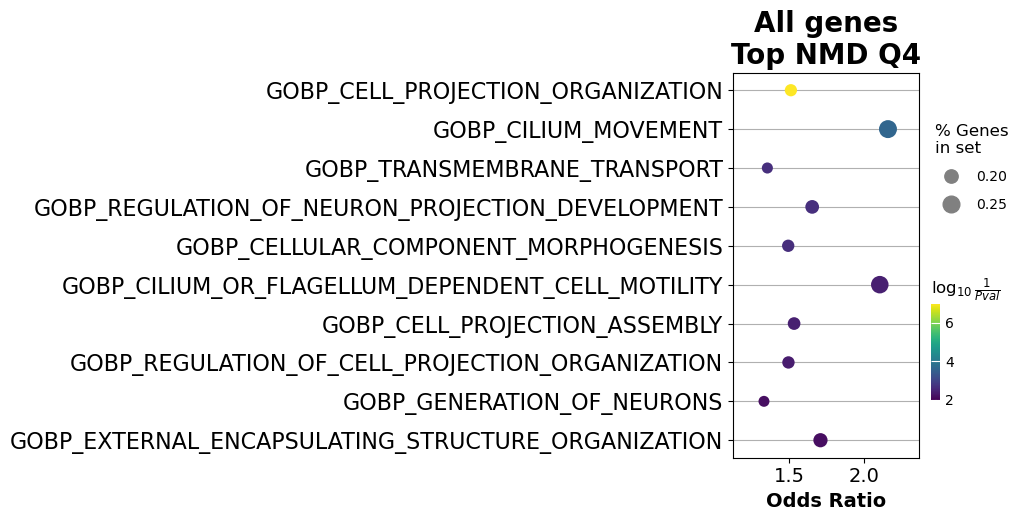

In [34]:
# gene_list = list(NMD_by_gene.sort_values('PSI').symbol)[-200:]
gene_list = list(NMD_by_gene.loc[NMD_by_gene.PSI > NMD_by_gene.PSI.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\nTop NMD Q4',cmap='viridis', size=8, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q4.png', dpi=300, bbox_inches='tight',)

In [137]:
df_bar = pd.DataFrame()
df_bar['All genes'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx), 
                                             ranks].mean(axis=0)

df_bar['Splicing factors'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Splicing factors'), 
                                             ranks].mean(axis=0)
df_bar['Transcription factors'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Transcription factors'), 
                                             ranks].mean(axis=0)
df_bar['Chromatin factors'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Chromatin factors'), 
                                             ranks].mean(axis=0)
df_bar['Other'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Other'), 
                                             ranks].mean(axis=0)

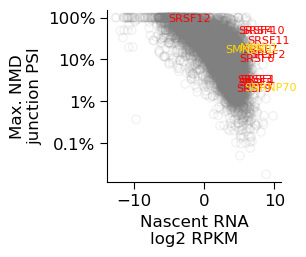

In [14]:
genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(RPKM.index)

other_sf = ['MBNL1', 'SNRNP70', 'SMNDC1']
other_sf_ensembl = genes.loc[genes.genes.isin(other_sf)].index.intersection(RPKM.index)


x = NMD_by_gene.RPKM
y = np.log10(NMD_by_gene.PSI)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.scatter(x,y, facecolor='none', edgecolor='grey', alpha=0.1)

# ax.scatter(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].RPKM, 
#                np.log10(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].PSI))

# resid = np.array(y) - poly_pred.T[0]
# NMD_by_gene['resid'] = resid

for sr_gene in srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='red', fontsize=8)
    
for sr_gene in other_sf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='gold', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.set_yticks([-3, -2, -1, 0])
ax.set_yticklabels(['0.1%', '1%', '10%', '100%'])

ax.set_xlabel('Nascent RNA\nlog2 RPKM', size=12)
ax.set_ylabel('Max. NMD\njunction PSI', size=12)

ax.tick_params(length=5, labelsize=12)

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.png', dpi=300, bbox_inches='tight',)

In [15]:
NMD_by_gene = NMD_by_gene.merge(exon_counts.groupby('gene').exon_count.sum().reset_index(), left_on='gene', right_on='gene')

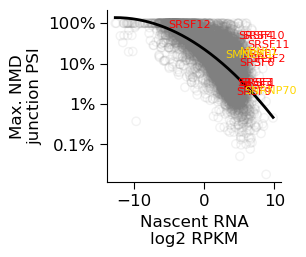

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

NMD_by_gene['log2_s_score'] = np.log2(NMD_by_gene.post_mean)

x = NMD_by_gene[['RPKM', 'log2_s_score']]

x = NMD_by_gene.RPKM
y = np.log10(NMD_by_gene.PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly2.fit_transform(np.array(x).reshape(-1, 1))
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,np.array(y).reshape(-1, 1))
poly_pred = poly_model.predict(X_poly)


genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(RPKM.index)

other_sf = ['MBNL1', 'SNRNP70', 'SMNDC1']
other_sf_ensembl = genes.loc[genes.genes.isin(other_sf)].index.intersection(RPKM.index)


x = NMD_by_gene.RPKM
y = np.log10(NMD_by_gene.PSI)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.scatter(x,y, facecolor='none', edgecolor='grey', alpha=0.1)

# ax.scatter(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].RPKM, 
#                np.log10(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].PSI))

# resid = np.array(y) - poly_pred.T[0]
# NMD_by_gene['resid'] = resid

for sr_gene in srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='red', fontsize=8)
    
for sr_gene in other_sf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='gold', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

df_pred = pd.DataFrame()
df_pred['x'] = list(x)
df_pred['y'] = [y[0] for y in poly_pred]

ax.plot(df_pred.sort_values('x').x, df_pred.sort_values('x').y, color='black', lw=2)


ax.set_yticks([-3, -2, -1, 0])
ax.set_yticklabels(['0.1%', '1%', '10%', '100%'])

ax.set_xlabel('Nascent RNA\nlog2 RPKM', size=12)
ax.set_ylabel('Max. NMD\njunction PSI', size=12)

ax.tick_params(length=5, labelsize=12)

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.png', dpi=300, bbox_inches='tight',)

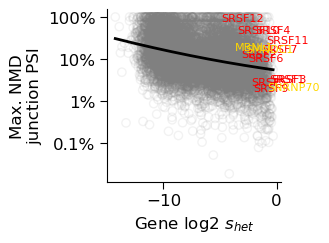

In [19]:
x = NMD_by_gene.log2_s_score
y = np.log10(NMD_by_gene.PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly2.fit_transform(np.array(x).reshape(-1, 1))
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,np.array(y).reshape(-1, 1))
poly_pred = poly_model.predict(X_poly)


genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(RPKM.index)

other_sf = ['MBNL1', 'SNRNP70', 'SMNDC1']
other_sf_ensembl = genes.loc[genes.genes.isin(other_sf)].index.intersection(RPKM.index)


x = NMD_by_gene.log2_s_score
y = np.log10(NMD_by_gene.PSI)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.scatter(x,y, facecolor='none', edgecolor='grey', alpha=0.1)

# ax.scatter(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].RPKM, 
#                np.log10(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].PSI))

# resid = np.array(y) - poly_pred.T[0]
# NMD_by_gene['resid'] = resid

for sr_gene in srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].log2_s_score, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='red', fontsize=8)
    
for sr_gene in other_sf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].log2_s_score, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='gold', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

df_pred = pd.DataFrame()
df_pred['x'] = list(x)
df_pred['y'] = [y[0] for y in poly_pred]

ax.plot(df_pred.sort_values('x').x, df_pred.sort_values('x').y, color='black', lw=2)


ax.set_yticks([-3, -2, -1, 0])
ax.set_yticklabels(['0.1%', '1%', '10%', '100%'])

ax.set_xlabel('Gene log2 $s_{het}$', size=12)
ax.set_ylabel('Max. NMD\njunction PSI', size=12)

ax.tick_params(length=5, labelsize=12)

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_log2_s_score_vs_NMD_PSI_scatter.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_log2_s_score_vs_NMD_PSI_scatter.png', dpi=300, bbox_inches='tight',)

In [136]:
from scipy.stats import zscore
NMD_by_gene['z_resid'] = zscore(NMD_by_gene.resid)

In [140]:
NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.union(other_sf_ensembl)), ['symbol', 'z_resid']]

,symbol,z_resid
1721,SRSF5,-0.061480
2105,SNRNP70,0.023149
2792,SRSF9,-0.603834
2826,SRSF3,0.155548
3177,SRSF7,2.328934
3234,SRSF4,3.276459
3278,SRSF11,3.271151
3552,SMNDC1,1.222893
3856,SRSF6,1.497825
5023,SRSF1,0.317298


In [89]:
# Haploinsufficiency

In [142]:
haplo = pd.read_csv('../data/Haploinsufficient_genes.Huang2010.txt', sep='\t', skiprows=1, 
                    names = ['chrom', 'start', 'end', 'gene', 'score', 'score_', 'x', 'y', 'z'])

haplo[['gene', 'score_2', 'percent']] = haplo.gene.str.split('|', expand=True)

is_haplo = []
is_haplo_lax = []
for gene in NMD_by_gene.symbol:
    if gene in list(haplo.loc[haplo.score > 0.95].gene):
        is_haplo.append(True)
    else:
        is_haplo.append(False)
    if gene in list(haplo.loc[haplo.score > 0.5].gene):
        is_haplo_lax.append(True)
    else:
        is_haplo_lax.append(False)
        
NMD_by_gene['is_haplo'] = is_haplo

NMD_by_gene['is_haplo_lax'] = is_haplo_lax
# NMD_by_gene['log2PSI'] = np.log2(NMD_by_gene.PSI)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 36 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'D', 'I', 'M', 'N', 'P', 'S', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'i', 'j', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'v', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 24, 26, 36, 39, 44, 48, 49, 51, 54, 68, 69, 70, 71, 72, 74, 76, 77, 79, 80, 81, 82, 85, 86, 87, 88, 89, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 36 glyphs after
INFO:fon

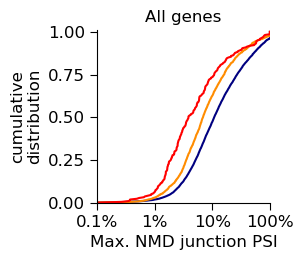

In [421]:
def plot_cdf(x, ax=None, **kwargs):
    x = sorted(x)
    y = np.linspace(0, 1, len(x))
    if not ax:
        plt.plot(np.log10(100*np.array(x)), y, **kwargs)
    else:
        ax.plot(np.log10(100*np.array(x)), y, **kwargs)
    
fig, ax = plt.subplots(figsize=(2.24, 2.24))


plot_cdf(NMD_by_gene.loc[(~NMD_by_gene.is_haplo_lax)].PSI.sort_values(), 
         ax=ax, c='navy', label='< 0.5',)

plot_cdf(NMD_by_gene.loc[(NMD_by_gene.is_haplo_lax) & (~NMD_by_gene.is_haplo)].PSI.sort_values(), 
         ax=ax, c='darkorange', label='0.5 - 95')

plot_cdf(NMD_by_gene.loc[NMD_by_gene.is_haplo].PSI.sort_values(), 
         ax=ax, c='red', label='> 95')



# ax.set_xlabel('NMD PSI')
# ax.set_ylabel('cumulative distribution')
# ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1, 0.75), title='Prob. gene is\nhaploinsufficient')

ax.set_ylabel('cumulative\ndistribution', size=12)
ax.set_xlabel('Max. NMD junction PSI', size=12)

# ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12, title = 'Junction reads')

ax.set_xlim([-1, 2.01])
ax.set_xticks([-1, 0, 1, 2])
ax.set_xticklabels(['0.1%', '1%', '10%', '100%'])
ax.set_ylim([0, 1.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)
ax.set_title('All genes')

plt.savefig(fig_dir + 'Supp_Haploinsufficient_NMD_PSI.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'Supp_Haploinsufficient_NMD_PSI.png', dpi=300, bbox_inches='tight')

In [ ]:
def plot_cdf(x, ax=None, log=True, **kwargs):
    x = sorted(x)
    y = np.linspace(0, 1, len(x))
    if log==True:
        x = np.log10(100*np.array(x))
    if not ax:
        plt.plot(x, y, **kwargs)
    else:
        ax.plot(x, y, **kwargs)
    
fig, ax = plt.subplots(figsize=(2.24, 2.24))


plot_cdf(NMD_by_gene.loc[(~NMD_by_gene.is_haplo_lax)].RPKM.sort_values(), log=False,
         ax=ax, c='navy', label='< 0.5',)

plot_cdf(NMD_by_gene.loc[(NMD_by_gene.is_haplo_lax) & (~NMD_by_gene.is_haplo)].RPKM.sort_values(), log=False,
         ax=ax, c='darkorange', label='0.5 - 95')

plot_cdf(NMD_by_gene.loc[NMD_by_gene.is_haplo].RPKM.sort_values(), log=False,
         ax=ax, c='red', label='> 95')



# ax.set_xlabel('NMD PSI')
# ax.set_ylabel('cumulative distribution')
# ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1, 0.75), title='Prob. gene is\nhaploinsufficient')

ax.set_ylabel('cumulative\ndistribution', size=12)
ax.set_xlabel('log2 RPKM', size=12)

# ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12, title = 'Junction reads')

# ax.set_xlim([-1, 2.01])
# ax.set_xticks([-1, 0, 1, 2])
# ax.set_xticklabels(['0.1%', '1%', '10%', '100%'])
ax.set_ylim([0, 1.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)
ax.set_title('All genes')

plt.savefig(fig_dir + 'Supp_Haploinsufficient_RPKM.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'Supp_Haploinsufficient_RPKM.png', dpi=300, bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'e', 'h', 'nonmarkingreturn', 's', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 72, 75, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 8 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'e', 'h', 'nonmarkingreturn', 's', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 72, 75, 86, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 

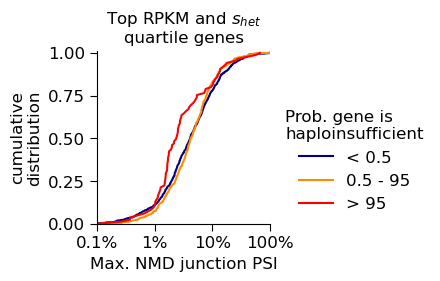

In [423]:
def plot_cdf(x, ax=None, **kwargs):
    x = sorted(x)
    y = np.linspace(0, 1, len(x))
    if not ax:
        plt.plot(np.log10(100*np.array(x)), y, **kwargs)
    else:
        ax.plot(np.log10(100*np.array(x)), y, **kwargs)
    
fig, ax = plt.subplots(figsize=(2.24, 2.24))


plot_cdf(top_genes.loc[(~top_genes.is_haplo_lax)].PSI.sort_values(), 
         ax=ax, c='navy', label='< 0.5',)

plot_cdf(top_genes.loc[(top_genes.is_haplo_lax) & (~top_genes.is_haplo)].PSI.sort_values(), 
         ax=ax, c='darkorange', label='0.5 - 95')

plot_cdf(top_genes.loc[top_genes.is_haplo].PSI.sort_values(), 
         ax=ax, c='red', label='> 95')



# ax.set_xlabel('NMD PSI')
# ax.set_ylabel('cumulative distribution')
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1, 0.75), title='Prob. gene is\nhaploinsufficient')

ax.set_ylabel('cumulative\ndistribution', size=12)
ax.set_xlabel('Max. NMD junction PSI', size=12)

# ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12, title = 'Junction reads')

ax.set_xlim([-1, 2.01])
ax.set_xticks([-1, 0, 1, 2])
ax.set_xticklabels(['0.1%', '1%', '10%', '100%'])
ax.set_ylim([0, 1.01])

ax.set_title('Top RPKM and $s_{het}$\nquartile genes')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)

plt.savefig(fig_dir + 'Supp_Haploinsufficient_NMD_PSI_important.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'Supp_Haploinsufficient_NMD_PSI_important.png', dpi=300, bbox_inches='tight')

In [93]:
intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)

In [369]:
sQTL_eQTL = pd.read_csv("/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/pi1/PairwisePi1Traits.P.all.txt.gz", sep='\t')
splicing_phenotypes = ['polyA.Splicing', 'polyA.Splicing.Subset_YRI', 'chRNA.Splicing']
expression_phenotypes = ['Expression.Splicing', 'Expression.Splicing.Subset_YRI']

sQTL_eQTL = sQTL_eQTL.loc[
    sQTL_eQTL.PC1.isin(splicing_phenotypes) & sQTL_eQTL.PC2.isin(expression_phenotypes)
].copy()

In [370]:
sQTL_eQTL["intron"] = sQTL_eQTL["P1"].str.replace(r'clu_\d+_', '', regex=True)
sQTL_eQTL["intron"] = "chr" + sQTL_eQTL["intron"]

In [371]:
sQTL_eQTL[['chrom.z', 'start.z', 'end.z', 'cluster']] = sQTL_eQTL.P1.str.split(':', expand=True)

In [373]:
min_indices = sQTL_eQTL.groupby('cluster')['p_permutation.x'].idxmin()

# Use the indices to filter the original DataFrame
sQTL_eQTL = sQTL_eQTL.loc[min_indices].copy()

In [375]:
sQTL_eQTL = sQTL_eQTL.merge(intron_annot, left_on='intron', right_on='junction')

In [376]:
sQTL_eQTL_haplo = sQTL_eQTL.merge(haplo, left_on='symbol', right_on='gene')

In [223]:
def plotQQ(p, ax=None, **kwargs):
    y = sorted(-np.log10(p))
    a = 1/len(p)
    x = -np.log10(np.linspace(a, 1, len(p)))[::-1]
    if ax:
        ax.scatter(x, y, **kwargs)
    else:
        plt.scatter(x, y, **kwargs)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'L', 'M', 'N', 'Q', 'T', 'U', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'v', 'w', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 39, 47, 48, 49, 52, 55, 56, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 93]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 44 

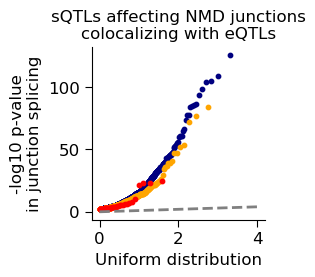

In [424]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))
plotQQ(sQTL_eQTL_haplo.loc[(sQTL_eQTL_haplo.score_2.astype(float) <= 0.5) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)]['p_permutation.x'],ax=ax, facecolor='navy', edgecolor=None, s=10, label='< 0.5')
plotQQ(sQTL_eQTL_haplo.loc[(sQTL_eQTL_haplo.score_2.astype(float) > 0.5) & (sQTL_eQTL_haplo.score_2.astype(float) <= 0.95) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)]['p_permutation.x'], ax=ax, facecolor='orange', edgecolor=None, s=10, label='0.5 - 95')
plotQQ(sQTL_eQTL_haplo.loc[(sQTL_eQTL_haplo.score_2.astype(float) > 0.95) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)]['p_permutation.x'], ax=ax, facecolor='red', edgecolor=None, s=10, label='> 95')
ax.plot([0, 4], [0, 4], linestyle='--', c='grey', linewidth=2)

# ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1, 0.75), title='Prob. gene is\nhaploinsufficient')

ax.set_ylabel('-log10 p-value\nin junction splicing', size=12)
ax.set_xlabel('Uniform distribution', size=12)
ax.set_title('sQTLs affecting NMD junctions\ncolocalizing with eQTLs')

# ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12, title = 'Junction reads')

# ax.set_xlim([-1, 2.01])
# ax.set_xticks([-1, 0, 1, 2])
# # ax.set_xticklabels(['0.1%', '1%', '10%', '100%'])
# ax.set_ylim([0, 1.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)


plt.savefig(fig_dir + 'Supp_Haploinsufficient_sQTL_pvalue.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'Supp_Haploinsufficient_sQTL_pvalue.png', dpi=300, bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'L', 'M', 'N', 'P', 'Q', 'T', 'U', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'four', 'g', 'greater', 'h', 'hyphen', 'i', 'j', 'l', 'less', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'two', 'u', 'v', 'w', 'x', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 24, 28, 31, 33, 39, 47, 48, 49, 51, 52, 55, 56, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 85, 86, 87, 88, 8

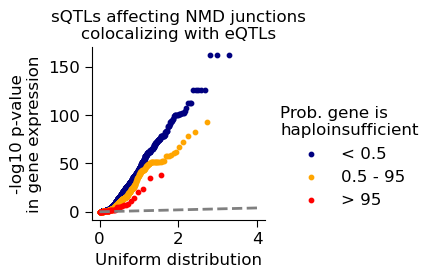

In [425]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))
plotQQ(sQTL_eQTL_haplo.loc[(sQTL_eQTL_haplo.score_2.astype(float) <= 0.5) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)].dropna()['trait.x.p.in.y'],ax=ax, facecolor='navy', edgecolor=None, s=10, label='< 0.5')
plotQQ(sQTL_eQTL_haplo.loc[(sQTL_eQTL_haplo.score_2.astype(float) > 0.5) & (sQTL_eQTL_haplo.score_2.astype(float) <= 0.95) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)].dropna()['trait.x.p.in.y'], ax=ax, facecolor='orange', edgecolor=None, s=10, label='0.5 - 95')
plotQQ(sQTL_eQTL_haplo.loc[(sQTL_eQTL_haplo.score_2.astype(float) > 0.95) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)].dropna()['trait.x.p.in.y'], ax=ax, facecolor='red', edgecolor=None, s=10, label='> 95')
ax.plot([0, 4], [0, 4], linestyle='--', c='grey', linewidth=2)

ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1, 0.75), title='Prob. gene is\nhaploinsufficient')

ax.set_ylabel('-log10 p-value\nin gene expression', size=12)
ax.set_xlabel('Uniform distribution', size=12)
ax.set_title('sQTLs affecting NMD junctions\ncolocalizing with eQTLs')

# ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12, title = 'Junction reads')

# ax.set_xlim([-1, 2.01])
# ax.set_xticks([-1, 0, 1, 2])
# # ax.set_xticklabels(['0.1%', '1%', '10%', '100%'])
# ax.set_ylim([0, 1.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)

plt.savefig(fig_dir + 'Supp_Haploinsufficient_eQTL_pvalue.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'Supp_Haploinsufficient_eQTL_pvalue.png', dpi=300, bbox_inches='tight')

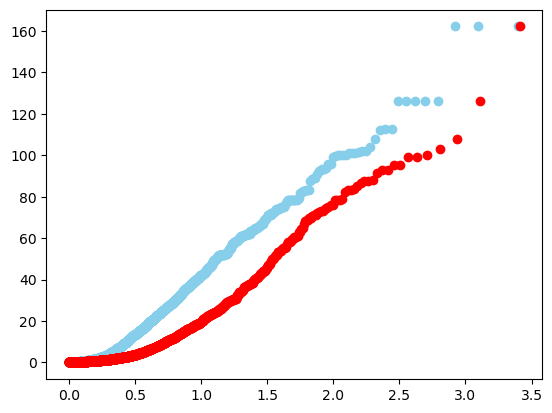

In [395]:
plotQQ(sQTL_eQTL_haplo.loc[sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)].dropna()['trait.x.p.in.y'], c='skyblue')
plotQQ(sQTL_eQTL_haplo.loc[sQTL_eQTL_haplo.SuperAnnotation.isin(PC)].dropna()['trait.x.p.in.y'], c='red')


In [ ]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

plot_cdf(sQTL_eQTL_haplo.loc[
    (sQTL_eQTL_haplo.score_2.astype(float) > 0.95) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)
]['beta.x'], ax=ax, c='red', log=False)

plot_cdf(sQTL_eQTL_haplo.loc[
    (sQTL_eQTL_haplo.score_2.astype(float) > 0.5) & (sQTL_eQTL_haplo.score_2.astype(float) < 0.95) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)
]['beta.x'], ax=ax, c='orange', log=False)
plot_cdf(sQTL_eQTL_haplo.loc[
    (sQTL_eQTL_haplo.score_2.astype(float) < 0.5) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)
]['beta.x'], ax=ax, c='navy', log=False)
plt.xlabel('sQTL beta', size=12)
plt.ylabel('cumulative\ndistribution', size=12)

plt.plot([0, 0], [0, 1], linestyle='--', c='grey')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)

plt.savefig(fig_dir + 'Supp_Haploinsufficient_sQTL_beta.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'Supp_Haploinsufficient_sQTL_beta.png', dpi=300, bbox_inches='tight')

In [ ]:
def plot_cdf(x, ax=None, log=True, **kwargs):
    x = sorted(x)
    y = np.linspace(0, 1, len(x))
    if log==True:
        x = np.log10(100*np.array(x))
    if not ax:
        plt.plot(x, y, **kwargs)
    else:
        ax.plot(x, y, **kwargs)
        
fig, ax = plt.subplots(figsize=(2.24, 2.24))
        
plot_cdf(
    sQTL_eQTL_haplo.loc[
        (sQTL_eQTL_haplo.score_2.astype(float) > 0.95) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)].dropna()['x.beta.in.y'].astype(float), 
    ax=ax, c='red', log=False, label='> 0.95')

plot_cdf(sQTL_eQTL_haplo.loc[
    (sQTL_eQTL_haplo.score_2.astype(float) > 0.5) & (sQTL_eQTL_haplo.score_2.astype(float) < 0.95) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)].dropna()['x.beta.in.y'], 
         ax=ax, c='orange', log=False, label='0.5 - 0.95')
plot_cdf(sQTL_eQTL_haplo.loc[(sQTL_eQTL_haplo.score_2.astype(float) < 0.5) & sQTL_eQTL_haplo.SuperAnnotation.isin(NMD)].dropna()['x.beta.in.y'], 
         ax=ax, c='navy', log=False, label='< 0.5')
ax.set_xlabel('eQTL beta')
ax.set_ylabel('cumulative\ndistribution', size=12)
ax.plot([0, 0], [0, 1], linestyle='--', c='grey')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)

ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1, 0.75), title='Prob. gene is\nhaploinsufficient')

# plt.plot([-0.5, -0.5], [0, 1], linestyle='--', c='grey')
# plt.plot([0.5, 0.5], [0, 1], linestyle='--', c='grey')

plt.savefig(fig_dir + 'Supp_Haploinsufficient_eQTL_beta.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'Supp_Haploinsufficient_eQTL_beta.png', dpi=300, bbox_inches='tight')